# Orchestration de conteneurs avec Kubernetes - Partie I

Dans le dernier guide, nous avons couvert la création et la gestion d'images de conteneurs, où nous avons discuté des images de conteneurs, de Dockerfile, de ses directives et de ses composants. Nous avons également examiné les meilleures pratiques pour rédiger un Dockerfile et créer et gérer des images eficaces. Nous avons ensuite examiné l'aplatissement des images Docker et avons plongé en profondeur dans les images sans distribution pour améliorer la sécurité des conteneurs. 

Enfin, nous avons créé un registre Docker privé. Nous allons maintenant approfondir l'orchestration des conteneurs. Nous allons apprendre à planifier et à exécuter des conteneurs à l'aide de l'orchestrateur de conteneurs le plus populaire - Kubernetes.

## Qu'est-ce que Kubernetes et pourquoi en ai-je besoin ?

À présent, vous devriez avoir une bonne compréhension de ce que sont les conteneurs et de la façon de créer et d'exécuter des conteneurs à l'aide de Docker. Cependant, la façon dont nous utilisions les conteneurs à l'aide de Docker n'était pas optimale du point de vue de la production. Permettez-moi de vous donner quelques considérations sur lesquelles réfléchir :

* Comme les conteneurs sont portables, ils peuvent s'exécuter sur n'importe quelle machine qui exécute Docker juste. Plusieurs conteneurs partagent également les ressources du serveur pour optimiser la consommation des ressources. Maintenant, pensez à une application de microservices qui comprend des centaines de conteneurs. Comment choisirez-vous la machine pour exécuter les conteneurs ? Que se passe-t-il si vous souhaitez planifier dynamiquement les conteneurs sur une autre machine en fonction de la consommation de ressources ?

* Les conteneurs offrent une évolutivité horizontale car vous pouvez créer une copie du conteneur et utiliser un équilibreur de charge devant un pool de conteneurs. Une façon de procéder consiste à décider à l'avance et à déployer le nombre souhaité de conteneurs, mais ce n'est pas une utilisation optimale des ressources. Et si je vous disais que vous devez mettre à l'échelle horizontalement vos conteneurs de manière dynamique avec le trafic, en d'autres termes, en créant des instances de conteneur supplémentaires pour gérer la charge supplémentaire lorsqu'il y a plus de trafic, et en les réduisant lorsqu'il y en a moins ?

* La vérification de l'état des conteneurs rend compte de l'état des conteneurs. Que faire si le conteneur n'est pas sain et que vous souhaitez le réparer automatiquement ? Que se passerait-il si un serveur entier tombait en panne et que vous vouliez programmer tous les conteneurs exécutés sur ce serveur vers un autre ?

* Étant donné que les conteneurs s'exécutent principalement au sein d'un serveur et peuvent se voir, comment puis-je m'assurer que seuls les conteneurs requis peuvent interagir avec le autre, quelque chose que nous faisons habituellement avec les machines virtuelles ? Nous ne pouvons pas faire de compromis sur la sécurité.

* Les plates-formes cloud modernes nous permettent d'exécuter des machines virtuelles à évolutivité automatique. Comment pouvons-nous utiliser cela du point de vue des conteneurs? Par exemple, si j'ai besoin d'une seule VM pour mes conteneurs pendant la nuit et cinq pendant la journée, comment puis-je m'assurer que les machines sont allouées dynamiquement lorsque nous en avons besoin ?

* Comment gérez-vous la mise en réseau entre plusieurs conteneurs s'ils sont partie d'un maillage de services plus complet ?



La réponse à toutes ces questions est un orchestrateur de conteneurs, et le plus populaire et le standard de facto pour cela est Kubernetes. 

Kubernetes est un orchestrateur de conteneurs open source. Il a d'abord été développé par un groupe d'ingénieurs de Google, puis open source à la Cloud Native Computing Foundation. Depuis lors, le buzz autour de Kubernetes ne s'est pas calmé, et pour une excellente raison : 


Kubernetes avec des conteneurs a complètement changé l'état d'esprit de la technologie et la façon dont nous considérions l'infrastructure. Au lieu de traiter les serveurs comme une machine dédiée à une application ou comme faisant partie d'une application, Kubernetes a permis de visualiser les serveurs comme une entité avec un runtime de conteneur installé. Ainsi, lorsque nous traitons les serveurs comme une configuration standard, nous pouvons pratiquement tout exécuter dans un cluster de serveurs. Ainsi, nous n'avons pas à planifier la haute disponibilité (HA), la reprise après sinistre (DR) et d'autres aspects opérationnels pour chaque application de votre pile technologique. Au lieu de cela, vous pouvez regrouper tous vos serveurs en une seule unité, un cluster Kubernetes, et conteneuriser toutes vos applications. Vous pouvez ensuite charger toutes les fonctions de gestion des conteneurs vers Kubernetes. Vous pouvez exécuter Kubernetes sur des serveurs bare-metal, des machines virtuelles et également en tant que service géré dans le cloud via plusieurs offres de service Kubernetes.

Kubernetes résout ces problèmes en fournissant une haute disponibilité, une évolutivité et aucun temps d'arrêt prêt à l'emploi. Il remplit essentiellement les fonctions suivantes pour les fournir :



* Fournit un plan de contrôle centralisé pour interagir avec celui-ci : le serveur d'API expose une liste d'API utiles avec lesquelles vous pouvez interagir pour appeler de nombreuses fonctions Kubernetes. Il fournit également une ligne de commande Kubernetes appelée kubectl pour interagir avec l'API à l'aide de commandes simples. L'idée d'avoir un plan de contrôle centralisé est de s'assurer que Kubernetes prend la décision finale de planifier des ressources telles que des conteneurs au sein de vos serveurs. De la même manière, vous confiez ce travail à Kubernetes plutôt que de le gérer vous-même



* Interagit avec l'environnement d'exécution du conteneur pour planifier les conteneurs : Kubernetes interagit avec l'environnement d'exécution du conteneur installé sur votre serveur pour planifier les conteneurs. Lorsque nous envoyons la demande de planification d'un conteneur à kube-apiserver, Kubernetes décide du serveur dont il a besoin pour planifier le conteneur en fonction de divers facteurs, puis interagit avec l'exécution du conteneur du serveur particulier via le composant kubelet. 

* Stocke la configuration attendue dans un magasin de données clé-valeur : Kubernetes applique la configuration anticipée du cluster et la stocke dans un magasin de données clé-valeur - etc. De manière régulière, Kubernetes s'assure en permanence que le cluster reste dans l'état souhaité. S'il y a un écart par rapport à l'état attendu, Kubernetes prendra toutes les mesures pour le ramener à la configuration souhaitée. Ainsi, Kubernetes s'assure que vos conteneurs sont opérationnels et sains également. 

* Fournit une couche d'abstraction réseau et une découverte de service : Kubernetes utilise une couche d'abstraction réseau pour permettre la communication entre vos conteneurs. Par conséquent, chaque conteneur se voit allouer une adresse IP virtuelle et Kubernetes garantit qu'un conteneur est accessible à partir d'un autre conteneur exécuté sur un serveur différent. Il fournit la mise en réseau nécessaire en utilisant un réseau superposé entre les serveurs. Du point de vue du conteneur, tous les conteneurs du cluster se comportent comme s'ils s'exécutaient sur le même serveur. Kubernetes utilise également un DNS pour permettre la communication entre les conteneurs via un nom de domaine. De la même manière, les conteneurs peuvent interagir les uns avec les autres en utilisant un nom de domaine au lieu d'une adresse IP, car les conteneurs sont éphémères, et s'ils sont recréés, vous obtiendrez une adresse IP diérente.

* Interagit avec le fournisseur de cloud : Kubernetes interagit avec le fournisseur de cloud pour mettre en service des objets tels que des équilibreurs de charge et des disques persistants. Donc, supposons que vous disiez à Kubernetes que votre application doit conserver les données et dénir un volume. Dans ce cas, Kubernetes demandera automatiquement un disque à votre fournisseur de cloud et le montera sur votre conteneur où qu'il soit exécuté. Vous pouvez également exposer votre application sur un équilibreur de charge externe en en informant Kubernetes. Kubernetes interagira avec votre fournisseur de cloud pour lancer un équilibreur de charge et le diriger vers vos conteneurs. Ainsi, de cette façon, vous pouvez faire tout ce qui concerne les conteneurs en interagissant simplement avec votre serveur d'API Kubernetes.


Kubernetes comprend plusieurs pièces mobiles qui prennent en charge chaque fonction dont nous avons discuté. Regardons maintenant l'architecture Kubernetes pour comprendre chacun d'eux

## Architecture Kubernetes

Kubernetes est constitué d'un cluster de nœuds. Il existe deux rôles possibles pour les nœuds dans Kubernetes : le plan de contrôle et les nœuds de travail. Les nœuds du plan de contrôle contrôlent le cluster Kubernetes dans son ensemble, planifiant les charges de travail, écoutant les demandes et d'autres aspects qui aident à exécuter vos charges de travail et à faire fonctionner le cluster. 

Ils forment généralement le cerveau du cluster. D'autre part, les nœuds de travail sont les moteurs du cluster Kubernetes et fournissent un calcul brut pour l'exécution de vos charges de travail de conteneur. L'architecture Kubernetes suit le modèle client-serveur via un serveur API. Toute interaction, y compris les interactions internes entre les composants, se produit via le serveur d'API Kubernetes. 

Par conséquent, le serveur d'API Kubernetes est connu comme le cerveau du plan de contrôle Kubernetes. Il existe également d'autres composants de Kubernetes, mais avant d'entrer dans les détails, examinons le schéma suivant pour comprendre l'architecture de haut niveau de Kubernetes :


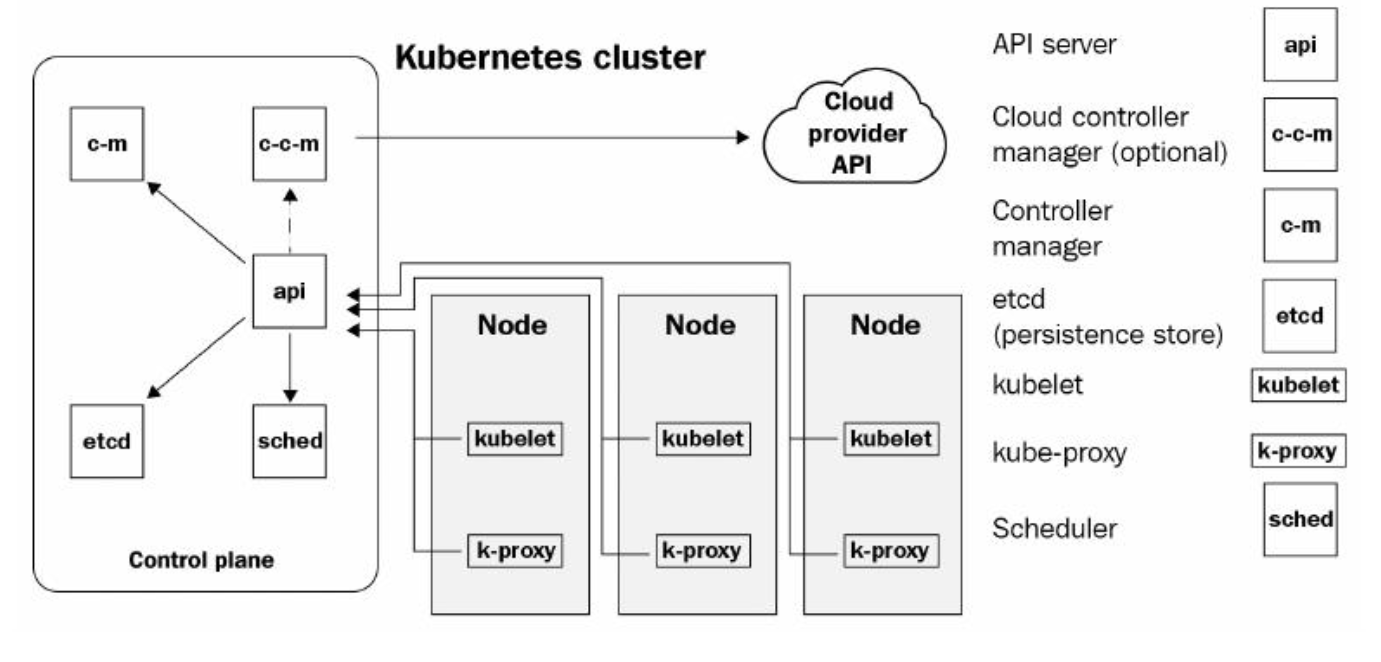


Le plan de contrôle comprend les composants suivants :

* API server : comme indiqué précédemment, le serveur d'API expose un ensemble d'API permettant aux acteurs externes et internes d'interagir avec Kubernetes. Toutes les interactions avec Kubernetes se produisent via le serveur API, comme le montre l'image. Si vous visualisez le cluster Kubernetes comme un navire, le serveur API est le capitaine du navire.

* Contrôleur manager : Le contrôleur manager est l'Ocier Exécutif du navire et est chargé de s'assurer que les ordres du capitaine sont suivis dans le cluster. D'un point de vue technique, le gestionnaire de contrôleur lit l'état actuel et l'état souhaité et prend toutes les mesures nécessaires pour déplacer l'état actuel vers l'état souhaité. Il contient un ensemble de contrôleurs qui interagissent avec les composants Kubernetes via le serveur API en fonction des besoins. Certains d'entre eux sont les suivants :

    * A. Contrôleur de nœud : il surveille lorsque le nœud tombe en panne et y répond en interagissant avec le planificateur Kube via le serveur d'API Kube pour planifier les pods sur un nœud sain.
    
    * B. Contrôleur de réplication : cela garantit que la quantité correcte de réplicas de conteneur dénie par les objets du contrôleur de réplication dans le cluster existe.
    * C. Contrôleur de points de terminaison : ils aident à fournir des points de terminaison à vos conteneurs via services.
    * D. Contrôleurs de comptes de service et de jetons : ils créent des comptes et des jetons par défaut pour les nouveaux espaces de noms


* Gestionnaire de contrôleur de cloud : il s'agit d'un gestionnaire de contrôleur facultatif que vous exécuteriez si vous exécutiez Kubernetes dans un cloud public, tel qu'AWS, Azure ou GCP. Le gestionnaire de contrôleur de cloud interagit avec les API du fournisseur de cloud pour provisionner des ressources telles que des disques persistants et des équilibreurs de charge que vous déclarez dans votre configuration Kubernetes.
* etcd : etcd est le journal de bord du navire. C'est là qu'existent tous les détails sur la configuration attendue. D'un point de vue technique, il s'agit d'un magasin clé-valeur où toute la configuration Kubernetes souhaitée est stockée. Le gestionnaire du contrôleur se réfère aux informations de cette base de données pour les changements d'action dans le cluster. 
* Planificateur : Les planificateurs sont le maître d'équipage du navire. Ils sont chargés de superviser le chargement et le déchargement des conteneurs sur le navire. Un planificateur Kubernetes planifie les conteneurs dans un nœud de travail qu'il trouve après avoir pris en compte la disponibilité des ressources pour l'exécuter, la haute disponibilité de votre application et d'autres aspects. 

* kubelet : les kubelets sont les marins du navire. Ils effectuent le chargement et le déchargement proprement dit des conteneurs d'un navire. Un kubelet interagit avec l'environnement d'exécution du conteneur sous-jacent pour exécuter des conteneurs sur instruction du planificateur d'un point de vue technique. Alors que la plupart des composants de Kubernetes peuvent s'exécuter en tant que conteneur, le kubelet est le seul composant qui s'exécute en tant que service systemd à la place. Ils s'exécutent généralement sur les nœuds de travail, mais si vous envisagez d'exécuter les composants du plan de contrôle en tant que conteneurs à la place, le kubelet s'exécutera également sur les nœuds du plan de contrôle.

* • kube-proxy : kube-proxy s'exécute sur chaque nœud de travail et fournit les composants de vos conteneurs pour interagir avec les composants réseau à l'intérieur et à l'extérieur de votre cluster. Ils sont un élément essentiel qui facilite le concept de service Kubernetes



Eh bien, cela fait beaucoup de pièces mobiles, mais la bonne nouvelle est qu'il existe des outils disponibles pour le configurer pour vous, et le provisionnement d'un cluster Kubernetes est très simple. Si vous utilisez un cloud public, vous n'êtes qu'à quelques clics et vous pouvez utiliser l'interface utilisateur Web ou l'interface de ligne de commande de votre cloud pour le provisionner très rapidement. 

Si vous disposez d'une installation sur site, vous pouvez utiliser kubeadm pour la configuration. Les étapes à cet égard sont bien documentées et comprises, et ce ne sera pas trop compliqué. Pour le développement et vos environnements CI/CD, vous pouvez utiliser Minikube ou KinD. 

Alors que Minikube est un cluster Kubernetes à nœud unique qui s'exécute sur votre machine, KinD peut exécuter un cluster Kubernetes à plusieurs nœuds en exécutant les nœuds en tant que conteneurs. Dans les deux cas, tout ce dont vous avez besoin est une machine virtuelle avec les ressources nécessaires et vous êtes prêt à partir. 

## Comprendre les pods Kubernetes

Les pods Kubernetes constituent le bloc de construction de base d'une application Kubernetes. Un pod contient un ou plusieurs conteneurs, et tous les conteneurs d'un pod sont toujours planifiés sur le même hôte. Habituellement, il y a un seul conteneur dans un pod, mais il existe des cas d'utilisation où vous souhaiterez peut-être planifier plusieurs conteneurs dans un seul pod.

 Il faut un certain temps pour comprendre pourquoi Kubernetes a commencé par le concept du pod au lieu d'utiliser conteneurs, mais il y a des raisons à cela, et vous l'apprécierez au fur et à mesure que vous acquerrez plus d'expérience avec l'outil. Pour l'instant, regardons un exemple simple d'un pod et comment le programmer dans Kubernetes

## Exécuter un pod

Nous commencerons par exécuter un conteneur NGINX dans un pod à l'aide de commandes impératives simples. Nous verrons ensuite comment nous pouvons le faire de manière déclarative. Pour accéder aux ressources de cette section, cd dans ce qui suit :


      $ cd ~/modern-devops/ch4/pod/

Pour exécuter un pod avec un seul conteneur NGINX, exécutez la commande suivante :

    $ kubectl run nginx --image=nginx

Pour vérifier si le pod est en cours d'exécution, exécutez la commande suivante :


    $ kubectl get pod
    NAME    READY   STATUS    RESTARTS   AGE
    nginx   1/1     Running   0          26s

Et c'est tout! 

Comme nous le voyons, le pod est maintenant en cours d'exécution. La commande kubectl run était le moyen impératif de créer des pods, mais il existe un autre moyen d'interagir avec Kubernetes - en utilisant des manifestes déclaratifs.

 Les manifestes Kubernetes sont des fichiers YAML ou JSON que vous pouvez utiliser pour déclarer la configuration souhaitée au lieu de tout dire à Kubernetes via une ligne de commande. La méthode est similaire à docker-compose



    Conseil
    Utilisez toujours la méthode déclarative pour créer des ressources
    Kubernetes dans des environnements de transfert et de production. Ils vous
    permettent de stocker et de versionner votre configuration Kubernetes dans
    un outil de gestion de code source tel que Git et d'activer GitOps. Vous
    pouvez utiliser des méthodes impératives pendant le développement, car les
    commandes ont un délai d'exécution plus rapide que l'utilisation de
    fichiers YAML

Regardons un exemple de manifeste de pod, nginx-pod.yaml :

    apiVersion: v1
    kind: Pod
    metadata:
      labels:
        run: nginx
      name: nginx
    spec:
      containers:
      - image: nginx
        imagePullPolicy: Always
        name: nginx
        resources:
          limits:
            memory: "200Mi"
            cpu: "200m"
          requests:
            memory: "100Mi"
            cpu: "100m"
      restartPolicy: Always


Comprenons d'abord le dossier. Le fichier contient les éléments suivants :

* apiVersion : il définit la version de la ressource que nous essayons de définir. Dans ce cas, comme il s'agit d'un pod et que c'est une ressource généralement disponible (GA), la version que nous allons utiliser est la v1.
* kind : cela dénit le type de ressource que nous voulons créer, un pod dans ce cas.

* metadata : la section des métadonnées dénit le nom et les étiquettes entourant cette ressource. Cela aide à identifier de manière unique la ressource ainsi qu'à regrouper plusieurs ressources à l'aide d'étiquettes.
* spec : Il s'agit de la section principale où nous définissons les spécifications réelles de la ressource.

* spec.containers : cette section dénit un ou plusieurs conteneurs qui forment le pod.

* spec.containers.name : le nom du conteneur, nginx-container dans ce cas.
* spec.containers.image : l'image du conteneur, nginx dans ce cas.

* spec.containers. imagePullPolicy : Cela peut être Always, IfNotPresent ou Never. S'il est défini sur Toujours, Kubernetes extrait toujours l'image du registre. S'il est défini sur IfNotPresent, Kubernetes extrait l'image uniquement si l'image n'est pas trouvée sur le nœud où le pod est planifié. S'il est défini sur Jamais, Kubernetes n'essaiera jamais d'extraire des images du registre et s'appuiera entièrement sur les images locales.

* spec.containers.resources : définit les demandes de ressources et les limites.
* spec.containers.resources.limit : définit les limites des ressources. Il s'agit de la quantité maximale de ressources que le pod peut allouer, et si la consommation de ressources augmente au-delà, le pod est expulsé.

* spec.containers.resources.limit.memory : définit la limite de mémoire.
* spec.containers.resources.limit.cpu : définit la limite du processeur.
* spec.containers.resources.requests : définit la ressource demandes. Il s'agit de la quantité minimale de ressources que le pod demanderait lors de la planification et ne sera pas planifiée sur un nœud qui ne peut pas l'allouer.
* spec.containers.resources.requests.memory : dénit la quantité de mémoire à demander.
* spec.containers.resources.requests.cpu : définit la quantité de cœurs de processeur à demander.
* spec.restartPolicy : définit la politique de redémarrage des conteneurs : toujours, en cas d'échec ou jamais. Ceci est similaire à la politique de redémarrage sur Docker.




Il y a d'autres paramètres sur le manifeste du pod, mais nous les explorerons au fur et à mesure de notre progression



      Conseils importants
      
      Définissez imagePullPolicy sur IfNotPresent, sauf si vous avez une bonne
      raison d'utiliser Always ou Never. Cela garantira que vos conteneurs
      démarrent rapidement et que vous ne téléchargez pas d'images inutilement.
      
      Utilisez toujours les demandes de ressources et les limites lors de la
      planification des pods. Cela garantit que votre pod est planifié dans un
      nœud approprié et n'épuise pas les ressources existantes. Vous pouvez
      également appliquer une stratégie de ressources par défaut au niveau du
      cluster pour vous assurer que vos développeurs ne causent aucun préjudice
      s'ils manquent cette section pour une raison quelconque.


Pour appliquer le manifeste, exécutez la commande suivante :


    $ kubectl apply -f nginx-pod.yaml




Le pod est entièrement hors des limites de l'hôte. Il s'exécute dans le réseau de conteneurs et, par défaut, Kubernetes n'autorise l'exposition d'aucun pod au réseau hôte, sauf si nous souhaitons explicitement l'exposer. Il existe deux manières d'accéder au pod - en utilisant la redirection de port avec le port kubectl port-forward ou en exposant le pod via une ressource de service








    



## Utilisation de port forwarding

Avant d'aborder le côté service, examinons l'utilisation de l'option de redirection de port. Pour exposer le pod à l'aide de la redirection de port, exécutez la commande suivante


    $ kubectl port-forward nginx 8080:80
    Forwarding from 127.0.0.1:8080 -> 80
    Forwarding from [::1]:8080 -> 80


Et l'invite est bloquée là-dessus. Cela signifie qu'il a ouvert une session de transfert de port et qu'il écoute sur le port 8080. Il transmettra automatiquement la demande qu'il reçoit sur le port 8080 au port NGINX 80.

Ouvrez une session de terminal en double, puis tournons-nous sur l'adresse précédente pour voir ce que nous avoir:



    $ curl 127.0.0.1:8080
    <!DOCTYPE html>
    <html>
    <head>
    <title>Welcome to nginx!</title>
    ...
    </html>


Nous pouvons voir que cela fonctionne lorsque nous obtenons la réponse NGINX par défaut. 

Maintenant, quelques points à retenir : lorsque nous utilisons le transfert de port HTTP, nous transférons les demandes de la machine cliente exécutant kubectl au pod, quelque chose de similaire au schéma suivant :


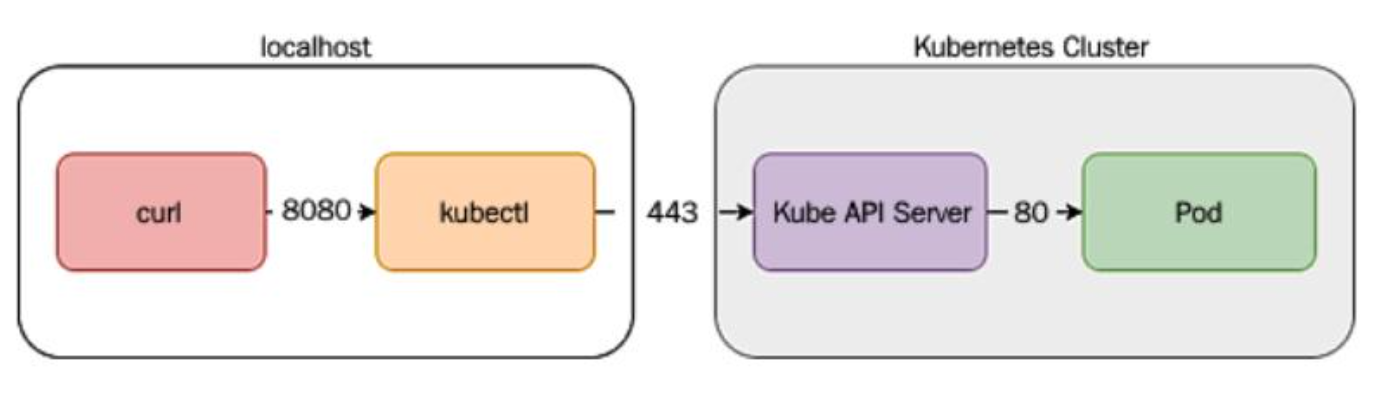

Lorsque vous exécutez un transfert de port kubectl, le client kubectl ouvre un tunnel TCP via le serveur API Kube, et le serveur API Kube transfère ensuite la connexion au pod approprié. 

Comme la connexion entre le client kubectl et le serveur API est cryptée, c'est un moyen très sécurisé d'accéder à votre pod, mais tenez vos chevaux avant de décider d'utiliser le transfert de port kubectl pour exposer les pods au monde extérieur. Cas d'utilisation pour l'utilisation du transfert de port kubectl :

 * Pour résoudre tout problème de pod. 
 * Pour accéder à un service Kubernetes interne, tel que le tableau de bord Kubernetes. C'est alors que vous ne souhaitez pas exposer le service au monde extérieur, mais autorisez uniquement les administrateurs et les utilisateurs Kubernetes à se connecter au tableau de bord. Il est supposé que seuls ces utilisateurs auront accès au cluster via kubectl


Pour toute autre chose, vous devez utiliser les ressources du service pour exposer votre pod, en interne ou en externe. Alors que nous couvrirons la ressource Service dans les sections à venir, examinons quelques opérations que nous pouvons effectuer avec un pod

## Dépannage des pods

Comme nous pouvons parcourir les journaux d'un conteneur à l'aide des journaux Docker, nous pouvons parcourir les journaux d'un conteneur dans un pod Kubernetes à l'aide de la commande kubectl logs. Si plusieurs conteneurs s'exécutent dans le pod, nous pouvons spécifier le nom du conteneur à l'aide de l'indicateur -c. Pour accéder aux journaux du conteneur, exécutez la commande suivante :


      $ kubectl logs nginx -c nginx


Comme le pod exécute un seul conteneur, nous n'avons pas besoin de spécifier l'indicateur -c. Vous pouvez donc également utiliser la commande suivante :


    $ kubectl logs nginx


Dans certains cas, vous souhaiterez peut-être installer un shell sur un conteneur en cours d'exécution et résoudre ce qui se passe à l'intérieur. Nous utilisons docker exec pour cela dans le monde Docker. De même, nous pouvons utiliser kubectl exec pour cela dans Kubernetes. Exécutez la commande suivante pour ouvrir une session shell avec le conteneur :


    $ kubectl exec -it nginx -- /bin/bash


Vous pouvez même exécuter des commandes spécifiques sans ouvrir de session shell. Par exemple, nous pouvons effectuer l'opération précédente avec une seule ligne, quelque chose comme ceci :


    $ kubectl exec nginx -- ls /etc/nginx


    Conseil
    Si vous modifiez des fichiers ou téléchargez des packages dans le conteneur
    en mode exec, ils persisteront jusqu'à ce que le pod actuel soit actif. Une
    fois le pod disparu, vous perdrez toutes les modifications. Par conséquent,
    ce n'est pas un excellent moyen de régler les problèmes. Vous ne devez
    diagnostiquer les problèmes qu'à l'aide d'exec, ancrer les modifications
    correctes dans une nouvelle image, puis la redéployer.


Lorsque nous avons examiné les conteneurs sans distribution dans le guide précédent, ils n'autorisaient pas exec dans le conteneur pour des raisons de sécurité. Il existe des images de débogage disponibles pour distroless qui vous permettront d'ouvrir une session shell à des fins de dépannage si vous le souhaitez.


    Astuce
    Par défaut, un conteneur s'exécute en tant qu'utilisateur root si vous
    n'avez pas spécifié l'utilisateur dans le Dockerfile lors de la création de
    l'image. Vous pouvez définir un attribut runAsUser dans le contexte de
    sécurité de votre pod si vous souhaitez exécuter votre pod en tant
    qu'utilisateur spécifique, mais ce n'est pas idéal. 
    La meilleure pratique consiste à cuire l'utilisateur dans l'image du
    conteneur


Nous avons discuté du dépannage des conteneurs en cours d'exécution, mais que se passe-t-il si les conteneurs ne démarrent pas pour une raison quelconque ? Regardons l'exemple suivant :

    $ kubectl run nginx-1 --image=nginx-1


Maintenant, essayons d'obtenir le pod et voyons par nous-mêmes :

    $ kubectl get pod nginx-1
    NAME      READY   STATUS             RESTARTS   AGE
    nginx-1   0/1     ImagePullBackOff   0          25s


Oups! Il y a maintenant une erreur et le statut est ImagePullBackOff. Eh bien, il semble qu'il y ait un problème avec l'image. Bien que nous comprenions que le problème vient de l'image, nous voulons comprendre le vrai problème, donc pour plus d'informations à ce sujet, nous pouvons décrire le pod à l'aide de la commande suivante :


    $ kubectl describe pod nginx-1



Maintenant, cela nous donne une mine d'informations concernant le pod, et si vous regardez la section des événements, vous trouverez une ligne spécifique qui nous dit ce qui ne va pas avec le pod :


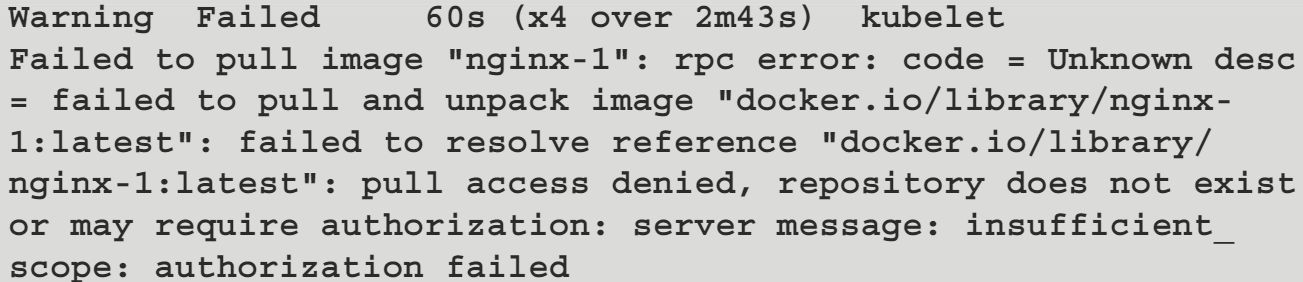





Donc, celui-ci nous dit que soit le référentiel n'existe pas, soit le référentiel existe mais il est privé, et donc l'autorisation a échoué.



Donc, comme nous savons tous que l'image n'existe pas, changeons l'image en une image valide. Pour ce faire, nous devons supprimer le pod, puis le recréer avec la bonne image. Pour supprimer le pod, exécutez la commande suivante :


    $ kubectl delete pod nginx-1


L'étape suivante consiste donc à recréer le pod avec la bonne image. Pour recréer le pod, exécutez la commande suivante :


    $ kubectl run nginx-1 --image=nginx

  
Maintenant, récupérons le pod, et il devrait fonctionner


      $ kubectl get pod nginx-1
      NAME      READY   STATUS    RESTARTS   AGE
      nginx-1   1/1     Running   0          42s


Et le pod fonctionne maintenant car nous avons résolu le problème d'image. Jusqu'à présent, nous avons réussi à exécuter uniquement des conteneurs à l'aide de pods, mais les pods sont des ressources très puissantes et vous aident également à gérer les conteneurs. 

Les pods Kubernetes fournissent un ensemble de sondes pour assurer la fiabilité de votre application. Voyons cela dans la section suivante.




## Assurer la fiabilité des pods 

Nous avons parlé des vérifications de l'état dans le guide sur Docker, et j'ai également mentionné que vous ne devriez pas l'utiliser au niveau Docker et utiliser à la place ceux fournis par votre orchestrateur de conteneurs. Kubernetes fournit trois sondes pour surveiller la santé de votre pod : la sonde de démarrage(Startup Probe), la sonde de vitalité (Liveness Probe)et la sonde de disponibilité (Readiness Probe). Le schéma suivant représente graphiquement les trois sondes :


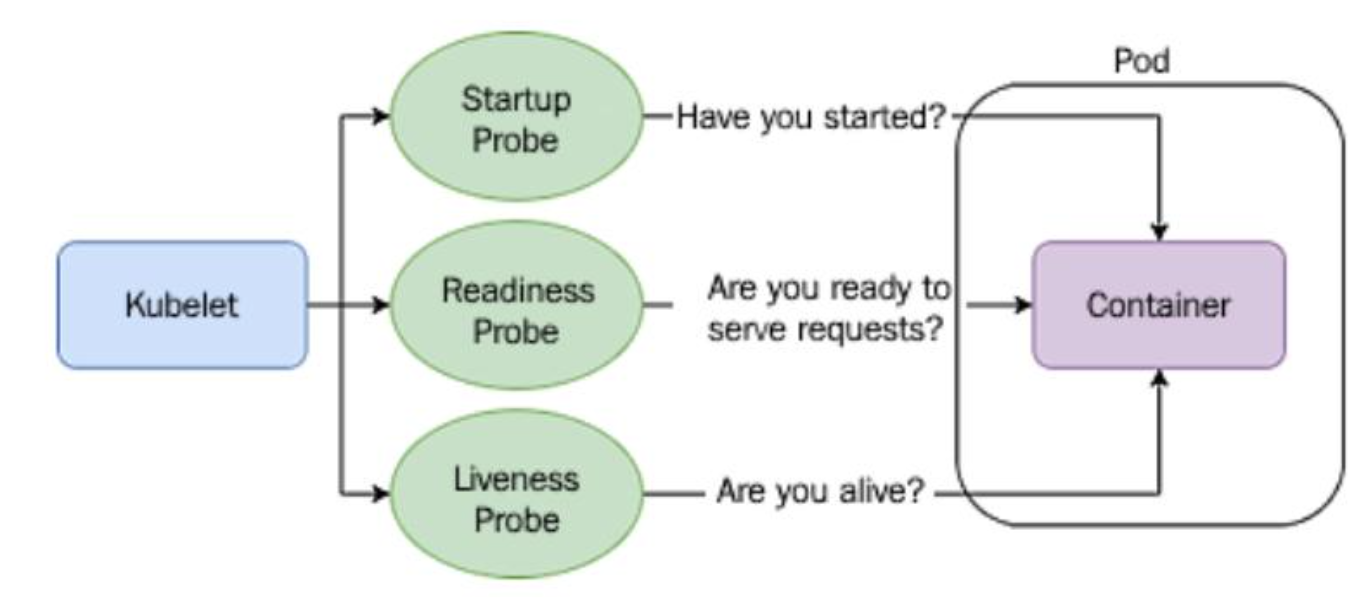

Regardons maintenant chacun à son tour et comprenons comment et quand les utiliser

* Startup probe Kubernetes utilise des sondes de démarrage pour vérifier si l'application a démarré. Vous pouvez utiliser des sondes de démarrage sur des applications qui démarrent lentement ou vous ne savez pas combien de temps cela peut prendre pour démarrer. Tant que la sonde de démarrage est active, elle désactive les autres sondes pour ne pas interférer avec son fonctionnement. Comme l'application n'a pas démarré tant que la sonde de démarrage ne l'a pas signalé, il ne sert à rien d'avoir d'autres sondes actives.


* Readiness probe: Readiness probes sont utilisés pour vérifier si un conteneur est prêt à servir des requêtes. Elles diffèrent des sondes de démarrage car, contrairement à la sonde de démarrage qui vérifie uniquement si l'application a démarré, la sonde de préparation garantit que le conteneur peut commencer à traiter les requêtes. Un pod est prêt lorsque tous les conteneurs du pod sont prêts. Les sondes de disponibilité garantissent qu'aucun trafic n'est envoyé à un pod si celui-ci n'est pas prêt. Par conséquent, il permet une meilleure expérience utilisateur.


* Liveness probe: Les sondes Liveness sont utilisées pour vérifier si un conteneur est en cours d'exécution et sain. La sonde vérifie périodiquement l'état de santé des conteneurs. Si un conteneur s'avère défectueux, la sonde de vivacité tuera le conteneur. Si vous avez défini la restartPolicy de votre pod sur Always ou OnFailure, Kubernetes redémarrera le conteneur. Par conséquent, cela améliore la fiabilité du service en détectant les blocages et en s'assurant que les conteneurs sont en cours d'exécution au lieu de simplement signaler comme en cours d'exécution. Voyons maintenant un exemple pour mieux comprendre les sondes.


Sondes en action

Améliorons le dernier manifeste et ajoutons-y quelques sondes pour créer le fichier manifeste nginx-probe.yaml suivant :



    apiVersion: v1
    kind: Pod
    metadata:
      labels:
        run: nginx
      name: nginx
    spec:
      containers:
      - image: nginx
        imagePullPolicy: Always
        name: nginx
        resources:
          limits:
            memory: "200Mi"
            cpu: "200m"
          requests:
            memory: "100Mi"
            cpu: "100m"
        startupProbe:
          exec:
            command:
            - cat
            - /usr/share/nginx/html/index.html
          failureThreshold: 30
          periodSeconds: 10
        readinessProbe:
          httpGet:
            path: /
            port: 80
          initialDelaySeconds: 5
          periodSeconds: 5
        livenessProbe:
          httpGet:
            path: /
            port: 80
          initialDelaySeconds: 5
          periodSeconds: 3
      restartPolicy: Always

Le fichier manifeste contient les trois sondes :

* La startup prob vérifie si le fichier /usr/share/nginx/html/index.html existe. Il continuera à le vérifier 30 fois à un intervalle de 10 secondes jusqu'à ce que l'un d'eux réussisse. Une fois le fichier détecté, la sonde de démarrage arrête de poursuivre la sonde.

* Le readinessProbe vérifie s'il existe un écouteur sur le port 80 et répond avec HTTP 2xx – 3xx sur le chemin /. Il attend initialement 5 secondes, puis vérifie le pod toutes les 5 secondes. S'il obtient une réponse 2xx – 3xx, il signalera le conteneur comme étant prêt et acceptera les demandes. 

* Le livenessProbe vérifie si le pod répond avec HTTP 2xx – 3xx sur le port 80 et le chemin /. Il attend initialement 5 secondes et sonde le conteneur toutes les 3 secondes. Supposons, lors d'une vérification, qu'il trouve que le pod ne répond pas aux temps de seuil d'échec (valeur par défaut à 3). Dans ce cas, il tuera le conteneur et le kubelet prendra les mesures appropriées en fonction de la stratégie de redémarrage du pod. 

Appliquons le fichier YAML à l'aide de la commande suivante et voyons ce que nous obtenons :


    $ kubectl apply -f nginx-probe.yaml

Maintenant, regardons les pods prendre vie à l'aide de la commande suivante :


    $ kubectl get pod -w
    NAME    READY   STATUS              RESTARTS   AGE
    nginx   0/1     ContainerCreating   0          8
    snginx   0/1     Running             0          14
    snginx   1/1     Running             0          23s



Comme nous le voyons, le pod est rapidement prêt à partir de l'état de fonctionnement. Cela prend environ 10 secondes pour que cela se produise. Cela est dû au fait que la sonde de disponibilité se déclenche 10 secondes après le démarrage de la nacelle. 

La sonde d'activité continue ensuite à surveiller l'état de santé du pod. Maintenant, faisons quelque chose qui brisera le contrôle d'activité. Imaginez un scénario où quelqu'un obtient un shell dans le conteneur et supprime certains fichiers importants à partir de là. Comment pensez-vous que la sonde de vivacité va réagir ? Regardons.



Supprimons le fichier /usr/share/nginx/html/index.html du conteneur, puis vérifions le comportement du conteneur à l'aide de la commande suivante :



    $ kubectl exec -it nginx -- rm -rf /usr/share/nginx/\
    html/index.html && kubectl get pod nginx -w
    NAME    READY   STATUS    RESTARTS   AGE
    nginx   1/1     Running   0          25
    snginx   0/1     Running   1          35
    snginx   0/1     Running   1          40
    snginx   1/1     Running   1          43s

Ainsi, pendant que nous surveillons le pod, la suppression initiale n'est détectée qu'au bout de 10 secondes. C'est à cause de la sonde de vivacité. Il essaie pendant 9 secondes, c'est-à-dire trois fois periodSeconds, car le failThreshold est défini par défaut sur 3, avant de déclarer le pod comme non sain et de tuer le conteneur.

 Dès qu'il tue le conteneur, le kubelet le redémarre car la stratégie de redémarrage du pod est définie sur Toujours. Nous voyons ensuite les sondes de démarrage et de préparation se déclencher, et bientôt le pod se prépare

 Par conséquent, quoi qu'il arrive, vos pods sont fiables et fonctionneront même si une partie de votre application est défectueuse.

 Comme nous l'avons vu précédemment, un pod peut contenir un ou plusieurs conteneurs. Examinons quelques-uns des cas d'utilisation dans lesquels vous souhaiterez peut-être utiliser plusieurs conteneurs au lieu d'un.

# Modèles de conception de pods multi-conteneurs 

Vous pouvez exécuter plusieurs conteneurs dans des pods de deux manières : en exécutant un conteneur en tant que conteneur d'initialisation ou en exécutant un conteneur en tant que conteneur d'assistance pour le conteneur principal. Explorons les deux approches dans les sous-sections suivantes.

# Conteneurs d'initialisation

Les conteneurs d'initialisation sont exécutés avant que le conteneur principal ne soit amorcé, et vous pouvez donc les utiliser pour initialiser votre environnement de conteneur avant que le conteneur principal ne prenne le relais, par exemple : 

* Un répertoire peut nécessiter un ensemble particulier de propriété ou d'autorisations avant de vouloir démarrer votre conteneur à l'aide de l'utilisateur non root.

* Vous souhaiterez peut-être cloner un référentiel Git avant de lancer le serveur Web.

* Vous pouvez ajouter un délai de démarrage.
* Vous pouvez générer la configuration de manière dynamique, comme pour les conteneurs qui souhaitent se connecter dynamiquement à un autre pod dont il n'a pas connaissance pendant la construction, mais devrait l'être pendant l'exécution.


Regardons maintenant un exemple pour voir les conteneurs init en action. Pour accéder aux ressources de cette section, cliquez sur ce qui suit :



    $ cd ~/modern-devops/ch4/multi-container-pod/


Servons le site Web example.com à partir de notre serveur Web nginx. Nous obtiendrons la page Web example.com et l'enregistrerons sous le nom index.html dans le répertoire HTML par défaut de nginx avant de démarrer nginx. Accédez au fichier manifeste, nginx-init.yaml, qui doit contenir les éléments suivants :





    apiVersion: v1
    kind: Pod
    metadata:
      name: nginx
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx-container
        image: nginx
        volumeMounts:
        - mountPath: /usr/share/nginx/html
          name: html-volume
      initContainers:
      - name: init-nginx
        image: busybox:1.28
        command: ['sh', '-c', 'mkdir -p /usr/share/nginx/html && wget -O /usr/share/nginx/html/index.html http://example.com']
        volumeMounts:
        - mountPath: /usr/share/nginx/html
          name: html-volume
      volumes:
      - name: html-volume
        emptyDir: {}




Si nous regardons la section spec du fichier manifeste, nous voyons les éléments suivants :

* containers : cette section définit un ou plusieurs conteneurs qui forment le pod.
* containers.name : le nom du conteneur, nginx-container dans ce cas.
* containers.image : l'image du conteneur, nginx dans ce cas.
*  containers.volumeMounts : cela dénit une liste de volumes qui doivent être montés sur le conteneur. Il est similaire aux volumes dont nous avons parlé au guide 3, Création et gestion d'images de conteneur.
*  containers.volumeMounts.mountPath : il dénit le chemin sur lequel monter le volume, /usr/share/nginx/html dans ce cas . Nous partagerons ce volume avec le conteneur d'initialisation afin que lorsque le conteneur d'initialisation télécharge le fichier index.html depuis example.com, ce répertoire contienne le même chier.

*  containers.volumeMounts.name : le nom du volume, html-volume dans ce cas.
* initContainers : cette section définit un ou plusieurs conteneurs d'initialisation qui s'exécutent avant les conteneurs principaux.
* initContainers.name : le nom du conteneur d'initialisation, init-nginx dans ce cas.
* initContainers.image : l'image du conteneur d'initialisation, busybox:1.28 dans ce cas.
* initContainers.command : la commande que la busybox doit exécuter. Dans ce cas, 'mkdir -p /usr/share/nginx/html && wget -O /usr/share/nginx/html/index.html http://example.com' téléchargera le contenu de example.com vers le /usr/share/nginx/html directory.
* initContainers.volumeMounts : nous allons monter le même volume que nous avons défini dans nginx-container sur ce conteneur. Ainsi, tout ce que nous sauvegardons dans ce volume apparaîtra automatiquement dans nginx-container.
* initContainers.volumeMounts.mountPath : cela dénit le chemin sur lequel monter le volume, /usr/share/nginx/html dans ce cas.




* initContainers.volumeMounts.name : le nom du volume, html-volume dans ce cas.* volumes : cette section définit un ou plusieurs volumes associés aux conteneurs du pod.
* volumes.name : le volume name, html-volume dans ce cas.
* volumes.emptyDir : is dénit un volume emptyDir. Il est similaire à un volume tmpfs dans Docker et n'est donc pas persistant et ne dure que la durée de vie du conteneur



Alors, allons de l'avant et appliquons le manifeste à l'aide de la commande suivante :


    $ kubectl apply -f nginx-init.yaml

Maintenant, pendant que le pod est créé, regardons le pod et voyons ce que nous obtenons en utilisant la commande suivante :



    $ kubectl get pod nginx -w
    NAME    READY   STATUS     RESTARTS   AGE
    nginx   0/1     Init:0/1   0          6s
    nginx   0/1     PodInitializing   0          7sn
    ginx   1/1     Running           0          17s


Initialement, nous voyons que le pod nginx affiche l'état de Init:0/1. Cela signifie que 0 initContainer sur 1 a commencé à s'initialiser. Après un certain temps, nous voyons que le pod signale l'état - PodInitializing, ce qui signifie que les conteneurs d'initialisation ont commencé à s'exécuter. Une fois que les conteneurs d'initialisation se sont exécutés avec succès, le pod signale un état d'exécution. Maintenant, une fois que le pod commence à s'exécuter, nous pouvons transférer le port de conteneur 80 vers le port d'hôte 8080 à l'aide de la commande suivante :


    $ kubectl port-forward nginx 8080:80



Ouvrez un terminal en double et essayez de boucler le localhost sur le port 8080 à l'aide de la commande suivante :


    $ curl localhost:8080



Et nous voyons l'exemple de réponse de domaine de notre serveur Web. Cela signifie que le conteneur d'initialisation a parfaitement fonctionné. Maintenant, comme vous l'avez peut-être compris, le cycle de vie des conteneurs d'initialisation se termine avant le début des conteneurs principaux, et un pod peut contenir un ou plusieurs conteneurs principaux. Par conséquent, examinons quelques modèles de conception que nous pouvons utiliser dans le conteneur principal.

## Modèle d'ambassadeur : 

le modèle d'ambassadeur tire son nom de l'ambassadeur, qui est un émissaire qui représente un pays à l'étranger. Vous pouvez également considérer un ambassadeur comme un mandataire d'une application particulière. Disons, par exemple, que vous avez migré l'une de vos applications Python Flask existantes vers des conteneurs et que l'un de vos conteneurs doit communiquer avec une base de données Redis. La base de données a toujours existé dans l'hôte local de votre système. Par conséquent, les détails de connexion à la base de données au sein de votre application contiennent un hôte local partout. Maintenant, vous pouvez adopter deux approches : 

*  Vous pouvez soit modifier le code de l'application et utiliser des cartes de configuration et des secrets (nous en parlerons plus tard) pour injecter la base de données les détails de connexion dans la variable d'environnement, ou

* Vous pouvez continuer à utiliser le code existant et utiliser un deuxième conteneur pour agir en tant que proxy TCP vers la base de données Redis. Le proxy TCP sera lié à la carte de configuration et aux secrets et contiendra les détails de connexion de la base de données Redis



La seconde approche résout notre problème si nous souhaitons faire une migration à l'identique. Nous pouvons utiliser des cong maps pour définir la configuration spécifique à l'environnement sans changer le code de l'application. Le schéma suivant montre l'approche

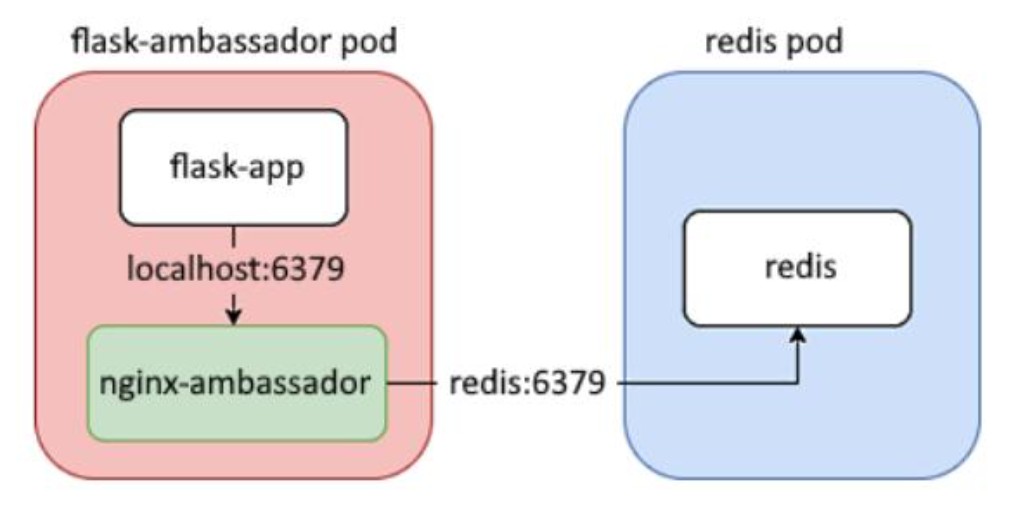

## Carte de configuration 

Une carte de configuration contient des paires clé-valeur que nous pouvons utiliser à diverses fins, telles que la définition de propriétés spécifiques à l'environnement ou l'injection d'une variable externe au démarrage du conteneur ou pendant l'exécution. configg map consiste à découpler l'application avec la conguration et à externaliser la conguration au niveau Kubernetes. C'est similaire à l'utilisation d'un fichier de propriétés Java, par exemple, pour définir la configuration spécifique à l'environnement. Le diagramme suivant l'explique magnifiquement :



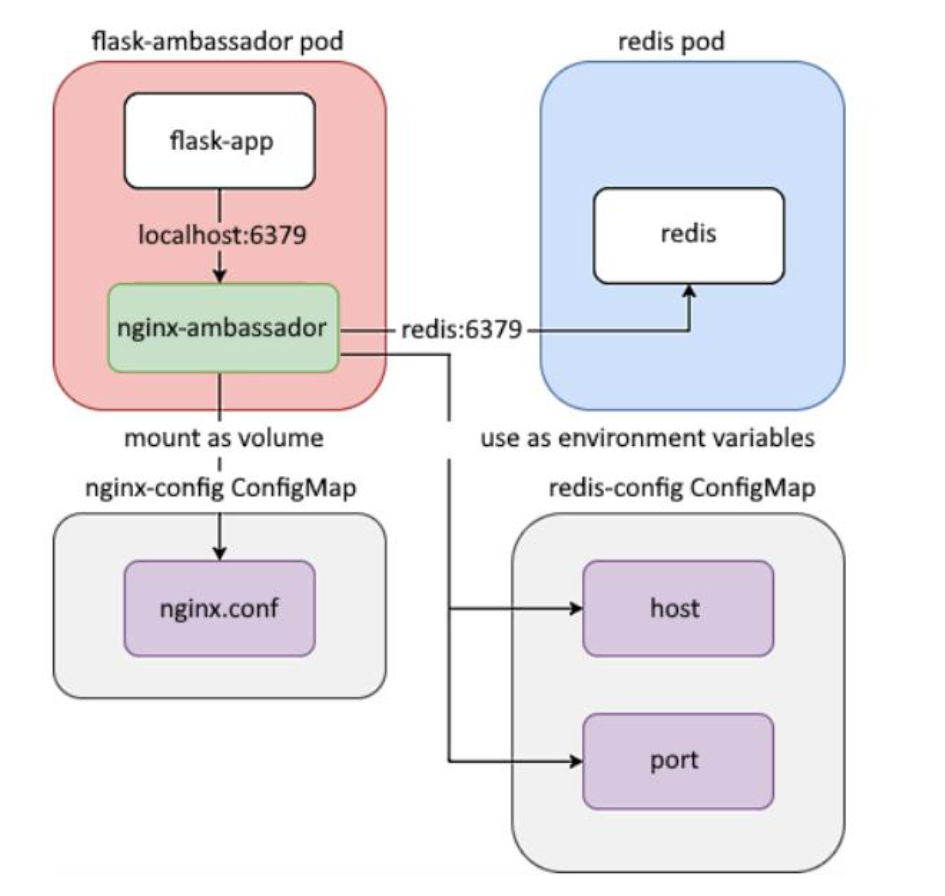

Nous allons utiliser ConfigMap pour dénir les propriétés de connexion de la base de données Redis externe dans le conteneur Ambassador.


## Example application

Alors, allons de l'avant et regardons le code de l'application pour cet exercice. app.py le de l'application Flask ressemble à ce qui suit:




    import time
    import redis
    from flask import Flask
    from datetime import datetime

    app = Flask(__name__)
    cache = redis.Redis(host='localhost', port=6379)

    def get_last_visited():
        try:
            last_visited = cache.getset('last_visited',str(datetime.now().strftime("%Y-%m-%d, %H:%M:%S")))
            if last_visited is None:
                return cache.getset('last_visited',str(datetime.now().strftime("%Y-%m-%d, %H:%M:%S")))
            return last_visited
        except redis.exceptions.ConnectionError as e:
            raise e

    @app.route('/')
    def index():
        last_visited = str(get_last_visited().decode('utf-8'))
        return 'Hi there! This page was last visited on {}.\n'.format(last_visited)


Nous devons également créer un Dockerfile, qui est le suivant :


    FROM python:3.7-alpine
    ENV FLASK_APP=app.py
    ENV FLASK_RUN_HOST=0.0.0.0
    RUN apk add --no-cache gcc musl-dev linux-headers
    COPY requirements.txt requirements.txt
    RUN pip install -r requirements.txt
    EXPOSE 5000
    COPY . .
    CMD ["flask", "run"]


.


    $ docker build -t <your_dockerhub_user>/flask-redis .

.

    $ docker push <your_dockerhub_user>/flask-redis


Comme vous l'avez peut-être remarqué, le code app.py définit le cache comme localhost:6379. Nous allons exécuter un conteneur ambassadeur sur localhost:6379. Le proxy tunnelisera la connexion vers le pod redis exécuté ailleurs.



Commençons par créer le pod redis à l'aide de la commande suivante :


    $ kubectl run redis --image=redis

Maintenant, exposons le pod redis aux ressources du cluster via une ressource Service. Cela permettra à n'importe quel pod du cluster de communiquer avec le pod redis à l'aide du nom d'hôte redis. Nous aborderons en détail les ressources du service Kubernetes dans le chapitre suivant :


    $ kubectl expose pod redis --port 6379


Cool, alors que le pod et la ressource Service sont opérationnels, travaillons sur le modèle ambassadeur. Nous devons d'abord définir deux cong maps.

 Le premier décrit les détails de l'hôte et du port redis, et le second définit le modèle de fichier nginx.conf pour qu'il fonctionne comme un proxy inverse. Ainsi, le fichier redis-config-map.yaml ressemble à ce qui suit :



    apiVersion: v1
    kind: ConfigMap
    metadata:
      name: redis-config
    data:
      host: "redis"
      port: "6379"



Le fichier yaml précédent définit une carte de configuration appelée redis-config, qui contient deux propriétés – host et port. Vous pouvez avoir plusieurs mappes de configuration, une pour chaque environnement. Le fichier nginx-config-map.yaml est le suivant :




    apiVersion: v1
    kind: ConfigMap
    metadata:
      name: nginx-config
    data:
      nginx.conf: |
        user nginx;
        worker_processes auto;
        error_log /var/log/nginx/error.log;
        pid /run/nginx.pid;
        include /usr/share/nginx/modules/*.conf;
        events {
            worker_connections 1024;
        }
        stream {
            server {
                listen     6379;
                proxy_pass stream_redis_backend;
            }
            upstream stream_redis_backend {
                server REDIS_HOST:REDIS_PORT;
            }
        }


Cette carte de configuration injecte le modèle nginx.conf en tant que valeur de carte de configuration. On peut monter ce fichier sur un volume puis le manipuler en fonction de l'environnement. Nous allons utiliser un initContainer pour initialiser le proxy avec la bonne configuration. Regardons maintenant le manifeste de configuration du pod flask-ambassador.yaml. Il y a plusieurs parties de ce fichier YAML. Regardons d'abord la section des conteneurs




    apiVersion: v1
    kind: Pod
    metadata:
      name: flask-ambassador
      labels:
        app: flask-ambassador
    spec:
      containers:
      - name: flask-app
        image: <your_dockerhub_user>/flask-redis
      - name: nginx-ambassador
        image: nginx
        volumeMounts:
        - mountPath: /etc/nginx
          name: nginx-volume

Il contient un conteneur appelé flask-app qui utilise l'image <your_dockerhub_user>/flask-redis que nous avons créée dans la section précédente. Le deuxième conteneur est le conteneur nginx-ambassadeur ; c'est le conteneur qui servira de proxy à redis. Par conséquent, nous avons monté le répertoire /etc/nginx sur un volume. Le volume est également monté sur le conteneur d'initialisation pour générer la configuration requise avant le démarrage de nginx.



Voici la section initContainers :

      initContainers:
      - name: init-nginx
        image: busybox:1.28
        command: ['sh', '-c', 'cp -L /config/nginx.conf /etc/nginx/nginx.conf && sed -i "s/REDIS_HOST/${REDIS_HOST}/g" /etc/nginx/nginx.conf && sed -i "s/REDIS_PORT/${REDIS_PORT}/g" /etc/nginx/nginx.conf']
        env:
          - name: REDIS_HOST
            valueFrom:
              configMapKeyRef:
                name: redis-config
                key: host
          - name: REDIS_PORT
            valueFrom:
              configMapKeyRef:
                name: redis-config
                key: port
        volumeMounts:
        - mountPath: /etc/nginx
          name: nginx-volume
        - mountPath: /config
          name: config

Il dénit un conteneur busybox – init-nginx. Le conteneur doit générer la configuration proxy nginx-ambassador pour communiquer avec Redis. Par conséquent, deux variables d'environnement sont présentes. Les deux variables d'environnement proviennent de la carte de configuration redis-config. En dehors de cela, nous avons également monté le fichier nginx.conf à partir de la carte de configuration nginx-config. La section de commande dans le conteneur init utilise les variables d'environnement pour remplacer les espaces réservés dans le fichier nginx.conf, et nous obtenons finalement un proxy TCP vers le backend Redis. La section volumes définit nginx-volume comme un emptyDir volume, et le volume de configuration est monté à partir de nginx.conf présent dans la carte de configuration nginx-config



      volumes:
      - name: nginx-volume
        emptyDir: {}
      - name: config
        configMap:
          name: nginx-config
          items:
          - key: "nginx.conf"
            path: "nginx.conf"

Alors, commençons maintenant à appliquer les fichiers yaml par étapes. Appliquez d'abord les deux cartes de configuration à l'aide des commandes suivantes :


    $ kubectl apply -f redis-config-map.yaml
    $ kubectl apply -f nginx-config-map.yaml

Appliquons la configuration du pod à l'aide de la commande suivante :


    $ kubectl apply -f flask-ambassador.yaml

Obtenez le pod pour voir si la configuration est correcte à l'aide de la commande suivante :



    $ kubectl get pod/flask-ambassador
    NAME               READY   STATUS    RESTARTS   AGE
    flask-ambassador   2/2     Running   0          10s

Comme le pod s'exécute avec succès maintenant, transférons le port 5000 vers l'hôte local pour certains tests à l'aide de la commande suivante :


    $ kubectl port-forward flask-ambassador 5000:5000